# Modelos de regresión
### Entender impacto de variables explicativas en el churn usando (E Commerce Dataset)
Explicar conclusiones sobre el impacto de las variables de acuerdo con el desempeño del mejor modelo implementado.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

#### Cargar datos y preprocesamiento

In [2]:
# Cargar los datos
df = pd.read_excel('E Commerce Dataset.xlsx', sheet_name='E Comm')

# Preprocesamiento
features_num = ['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
features_cat = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OneHotEncoder(), features_cat)])

df_preprocessed = preprocessor.fit_transform(df)

### Definir los modelos

In [3]:
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier())])

### Dividir los datos

In [4]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Ajustar y evaluar los modelos

In [5]:
# Rellenar los valores NaN en las columnas numéricas con la media
for col in features_num:
    X_train[col] = X_train[col].fillna(X_train[col].mean())
    X_test[col] = X_test[col].fillna(X_train[col].mean())

# Rellenar los valores NaN en las columnas categóricas con la moda
for col in features_cat:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
    X_test[col] = X_test[col].fillna(X_train[col].mode()[0])

# Ahora puedes ajustar y evaluar tus modelos
model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("AUC: ", roc_auc_score(y_test, y_pred_lr))

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("AUC: ", roc_auc_score(y_test, y_pred_rf))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       939
           1       0.75      0.49      0.59       187

    accuracy                           0.89      1126
   macro avg       0.83      0.73      0.76      1126
weighted avg       0.88      0.89      0.88      1126

AUC:  0.7273410671268217
Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       939
           1       0.97      0.79      0.87       187

    accuracy                           0.96      1126
   macro avg       0.96      0.89      0.92      1126
weighted avg       0.96      0.96      0.96      1126

AUC:  0.8903857215264844


### Gráficas de rendimiento

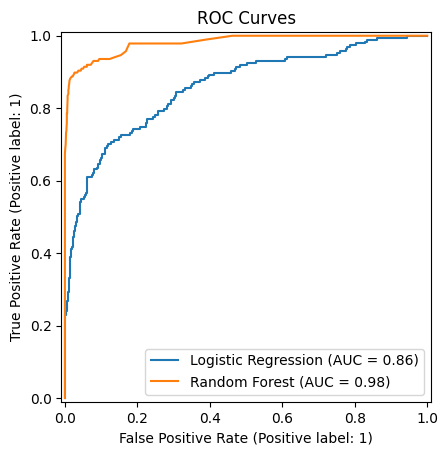

In [6]:
# Graficar la curva ROC para ambos modelos en el mismo gráfico
ax = plt.gca()
roc_display_lr = RocCurveDisplay.from_estimator(model_lr, X_test, y_test, ax=ax, name='Logistic Regression')
roc_display_rf = RocCurveDisplay.from_estimator(model_rf, X_test, y_test, ax=ax, name='Random Forest')
plt.title('ROC Curves')
plt.show()

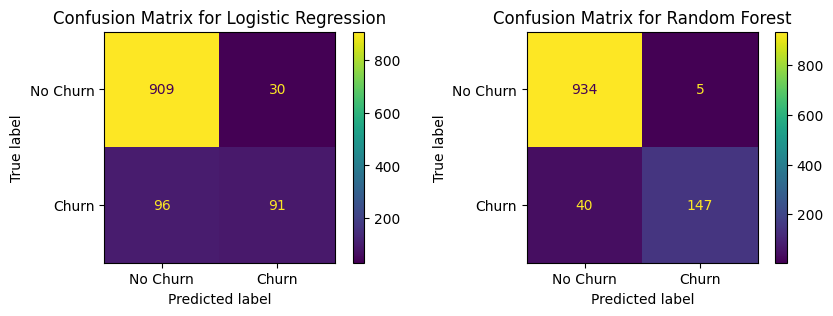

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Graficar la matriz de confusión para la Regresión Logística
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test, ax=ax[0], display_labels=['No Churn', 'Churn'])
ax[0].set_title('Confusion Matrix for Logistic Regression')

# Graficar la matriz de confusión para el Bosque Aleatorio
ConfusionMatrixDisplay.from_estimator(model_rf, X_test, y_test, ax=ax[1], display_labels=['No Churn', 'Churn'])
ax[1].set_title('Confusion Matrix for Random Forest')

plt.show()

#### Uso del mejor modelo

In [8]:
best_model = model_rf

# Extraer la importancia de las características
importances = best_model.named_steps['classifier'].feature_importances_

# Obtener los nombres de las características después del preprocesamiento
onehot_columns = list(model_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=features_cat))
feature_names = features_num + onehot_columns

# Crear un DataFrame para visualizar la importancia de las características
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

print(feature_importances)

                                  feature  importance
0                                  Tenure    0.203752
12                         CashbackAmount    0.095014
2                         WarehouseToHome    0.067293
7                                Complain    0.061972
11                      DaySinceLastOrder    0.060627
6                         NumberOfAddress    0.058571
8             OrderAmountHikeFromlastYear    0.052743
5                       SatisfactionScore    0.044813
4                NumberOfDeviceRegistered    0.035412
10                             OrderCount    0.030038
9                              CouponUsed    0.027749
1                                CityTier    0.023720
33                   MaritalStatus_Single    0.023172
3                          HourSpendOnApp    0.020142
32                  MaritalStatus_Married    0.014925
13          PreferredLoginDevice_Computer    0.014551
27    PreferedOrderCat_Laptop & Accessory    0.014358
24                          

### Gráfico de las características

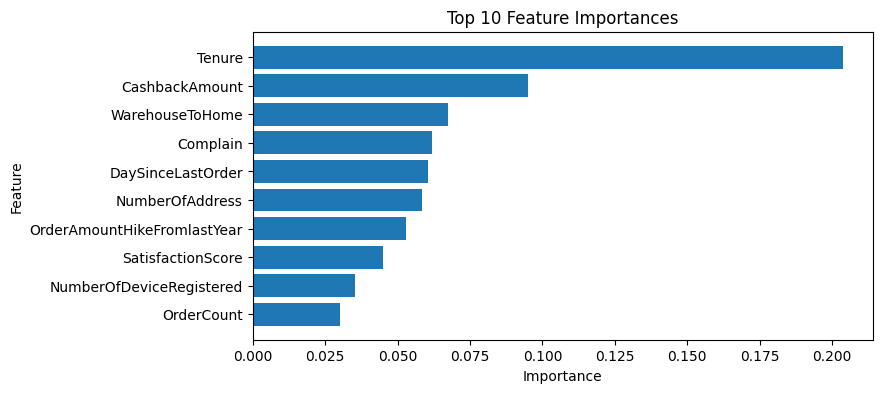

In [9]:
# Crear un gráfico de barras para visualizar la importancia de las características
plt.figure(figsize=(8, 4))
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
plt.barh(feature_importances_sorted['feature'][:10], feature_importances_sorted['importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté en la parte superior
plt.show()